# Solving the SWE using NN + FNO

In [151]:
# Load packages
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import scipy.io
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, SimpleRNN, BatchNormalization, Dropout

from tensorflow.keras.optimizers import Adam
import tensorflow as tf


## Solve the SWE using NN

In [75]:
# Load a single .mat file
filename = 'dataFNO/data_sigma_no1.mat'
mat_data = scipy.io.loadmat(filename)

# Print the keys of the loaded data
print(mat_data.keys())

# Extract the necessary data (x and h_all) from the loaded data
x = mat_data['x'].flatten()
h_all = mat_data['h_all'][1:,:]
t = mat_data['time_all'].flatten()

h_all.shape

dict_keys(['__header__', '__version__', '__globals__', 'h0', 'h_all', 'sigma', 'time_all', 'u_all', 'x'])


(304, 100)

In [76]:
h_all.shape

(304, 100)

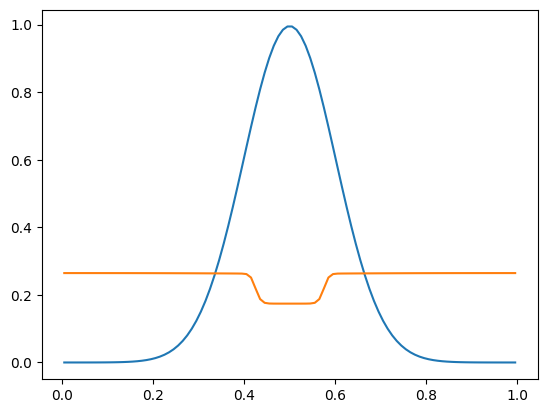

In [77]:
plt.plot(x, h_all[0])
plt.plot(x, h_all[-1])

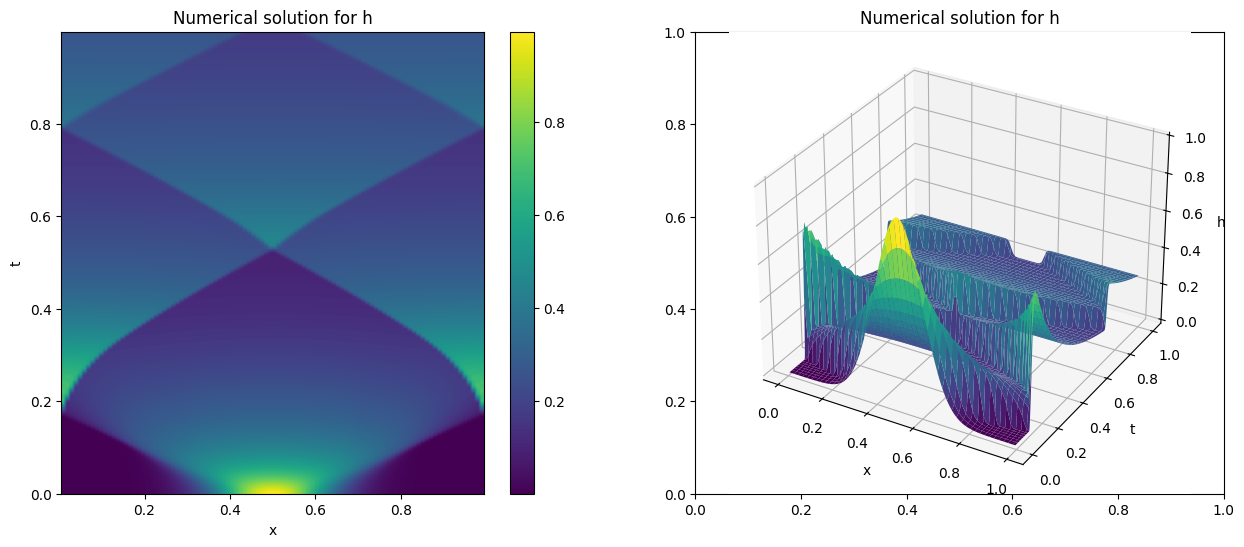

In [78]:
# Plot the data in x,t space
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
img = ax[0].imshow(h_all, extent=[x[0], x[-1], t[-1], t[0]], aspect='auto')
plt.colorbar(img, ax=ax[0])
ax[0].set_title('Numerical solution for h')
ax[0].set_xlabel('x')
ax[0].set_ylabel('t')
ax[0].invert_yaxis()

# Plot in 3D
X, T = np.meshgrid(x, t)
ax[1] = fig.add_subplot(122, projection='3d')
ax[1].plot_surface(X, T, h_all, cmap='viridis')
ax[1].set_title('Numerical solution for h')
ax[1].set_xlabel('x')
ax[1].set_ylabel('t')
ax[1].set_zlabel('h')
plt.show()


In [79]:
# Define percentage of data to use for training
P = 0.8

# Split the data into training and testing sets
n_train = int(P * len(t))

h_train = h_all[:n_train, :]
h_test = h_all[n_train:, :]

# Split X and T into training and testing sets
X_train = X[:n_train, :]
X_test = X[n_train:, :]
T_train = T[:n_train, :]
T_test = T[n_train:, :]

### (i) FNN

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.8816 - val_loss: 0.0925
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0691 - val_loss: 0.1125
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0502 - val_loss: 0.0926
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0206 - val_loss: 0.0235
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0189 - val_loss: 0.0243
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0198 - val_loss: 0.0086
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0121 - val_loss: 0.0072
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0178 - val_loss: 0.0109
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0149 - val_loss: 0.0104
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0188 - val_loss: 0.0058
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0148 - val_loss: 0.0078
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

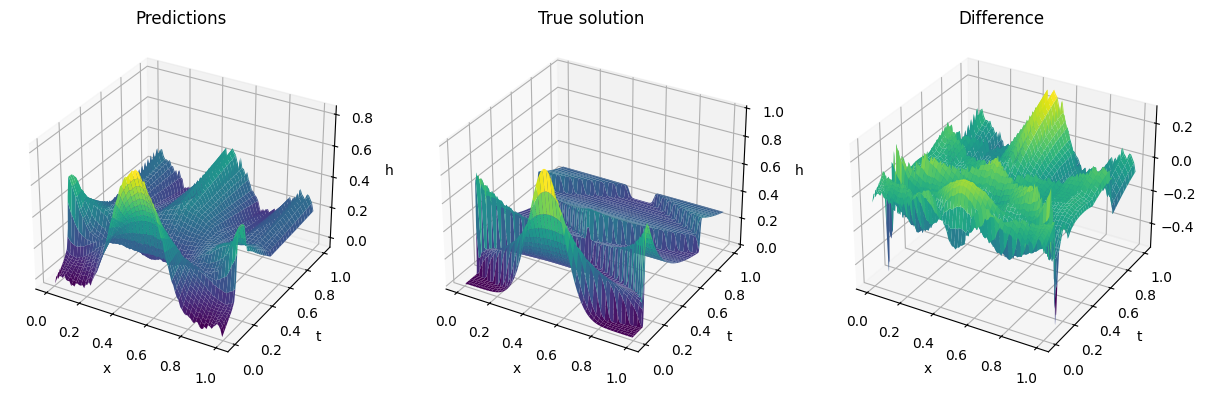

In [161]:
X, T = np.meshgrid(x, t)

# Define the NN model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X.shape[1] + T.shape[1],)))
model.add(BatchNormalization())  # Batch normalization layer
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dense(64, activation='relu'))
model.add(Dense(h_all.shape[1])) # Output layer

# Compile the model
learning_rate = 0.01 # Adjust this value as needed
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = model.fit(np.hstack([X_train, T_train]), h_train, epochs=100, batch_size=16, validation_split=0.2)

# Evaluate the model on the test data
loss = model.evaluate(np.hstack([X_test, T_test]), h_test)
print(f'Test loss: {loss}')

# Make predictions on the testing data
predictions = model.predict(np.hstack((X, T)))

# Plot the predictions
fig = plt.figure(figsize=(15, 6))

ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(X, T, predictions, cmap='viridis')
ax.set_title('Predictions')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('h')

ax = fig.add_subplot(132, projection='3d')
ax.plot_surface(X, T, h_all, cmap='viridis')
ax.set_title('True solution')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('h')

ax = fig.add_subplot(133, projection='3d')
ax.plot_surface(X, T, predictions - h_all, cmap='viridis')
ax.set_title('Difference')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('h')

plt.show()


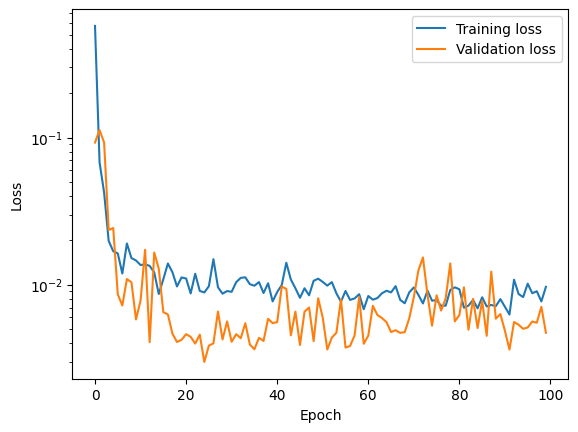

In [166]:
# Plot the training and validation loss
plt.semilogy(history.history['loss'], label='Training loss')
plt.semilogy(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#### Calculate error in the different time steps

RMSE: 0.07914734436319759


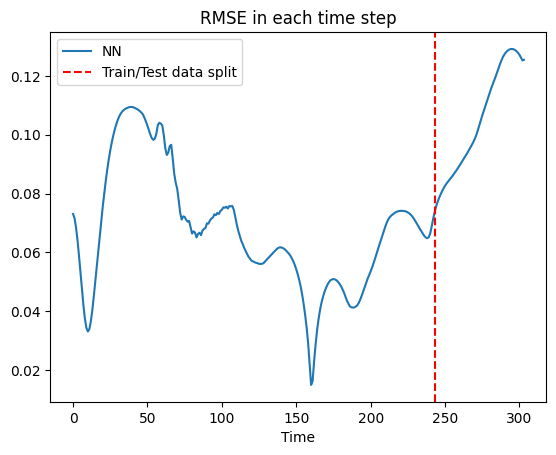

In [168]:
# Calculate RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Calculate the RMSE for the predictions
rmse_val = rmse(predictions, h_all)
print(f'RMSE: {rmse_val}')

# Plot error
error_NN = []

for i in range(h_all.shape[0]):
    error_NN.append(rmse(predictions[i], h_all[i]))

plt.plot(error_NN, label='NN')
plt.axvline(x=n_train, color='r', linestyle='--', label='Train/Test data split')
plt.xlabel('Time')
plt.title('RMSE in each time step')
plt.legend()
plt.show()


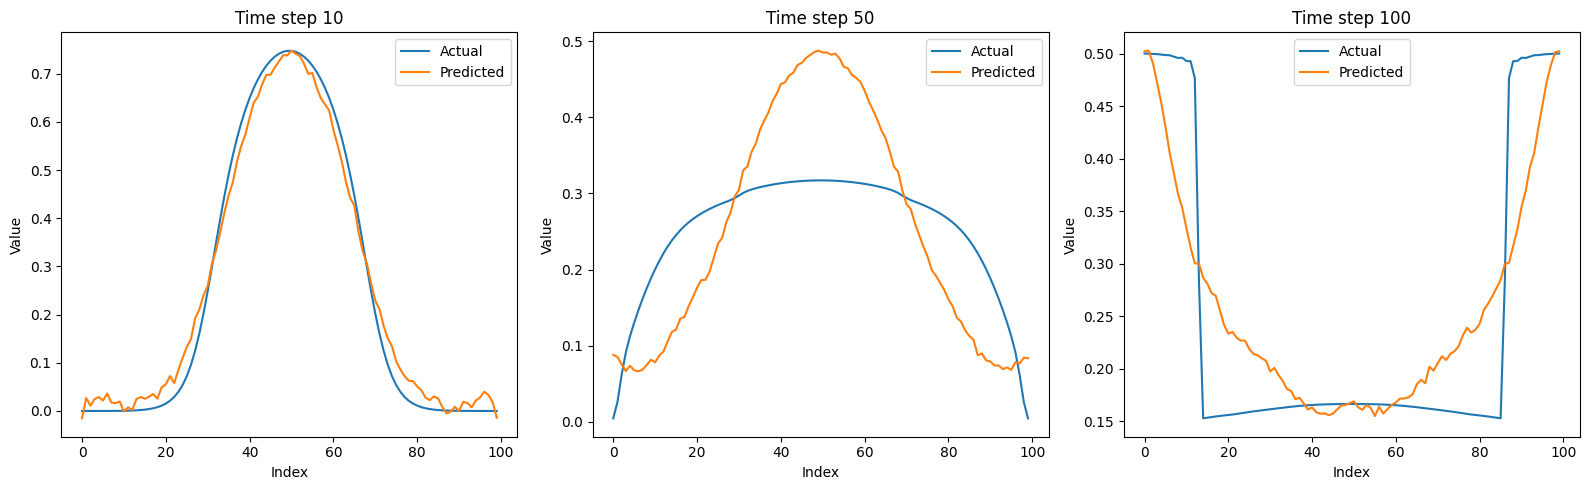

In [169]:
# Define the indices for the plots
indices = [10, 50, 100]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(indices), figsize=(16, 5))

# Plot for each index
for i, index in enumerate(indices):
    ax = axes[i]
    ax.plot(h_all[index], label='Actual')
    ax.plot(predictions[index], label='Predicted')
    ax.legend()
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.set_title(f'Time step {index}')

# Save the figure
plt.tight_layout()
plt.show()

### (ii) LSTM

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0820 - val_loss: 0.0503
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0659 - val_loss: 0.0169
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 579924351369871360.0000 - val_loss: 2688449280.0000
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0451 - val_loss: 0.0245
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0558 - val_loss: 0.0293
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0580 - val_loss: 0.0297
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0590 - val_loss: 0.0289
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0550 - val_loss: 0.0278
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0559 - val_loss: 0.0266
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0569 - val_loss: 0.0254
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0547 - val_loss: 0.0243
Epoch 12/100
13/13 ━━━━━━

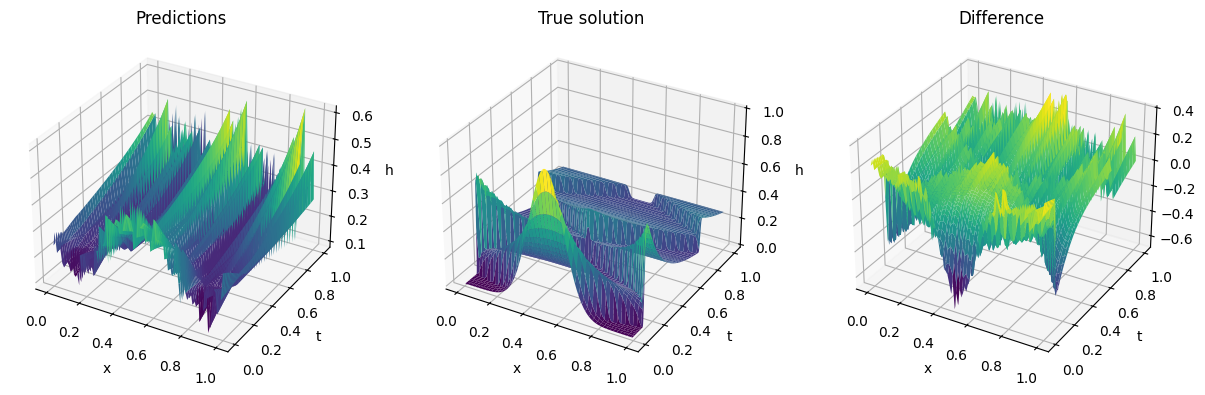

In [137]:
X, T = np.meshgrid(x, t)

# Define the RNN model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X.shape[1] + T.shape[1], 1)))
model.add(Dense(64, activation='relu'))
model.add(Dense(h_all.shape[1])) # Output layer

# Compile the model
learning_rate = 0.001 # Adjust this value as needed
optimizer = Adam(learning_rate=learning_rate, clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = model.fit(np.hstack([X_train, T_train]), h_train, epochs=100, batch_size=16, validation_split=0.2)

# Evaluate the model on the test data
loss = model.evaluate(np.hstack([X_test, T_test]), h_test)

# Make predictions on the testing data
predictions = model.predict(np.hstack((X, T)))

# Plot the predictions
fig = plt.figure(figsize=(15, 6))

ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(X, T, predictions, cmap='viridis')
ax.set_title('Predictions')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('h')

ax = fig.add_subplot(132, projection='3d')
ax.plot_surface(X, T, h_all, cmap='viridis')
ax.set_title('True solution')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('h')

ax = fig.add_subplot(133, projection='3d')
ax.plot_surface(X, T, predictions - h_all, cmap='viridis')
ax.set_title('Difference')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('h')

plt.show()

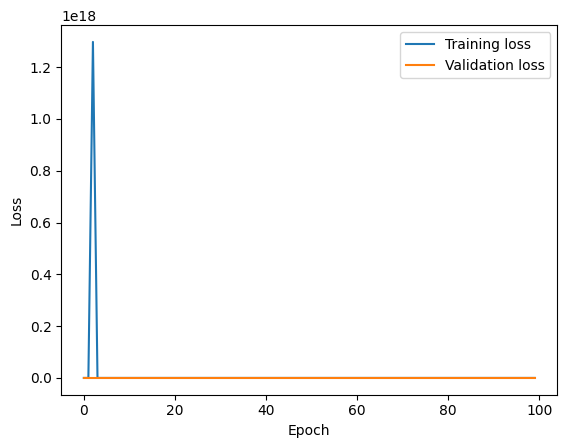

In [139]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()



RMSE: 0.12286311089784206


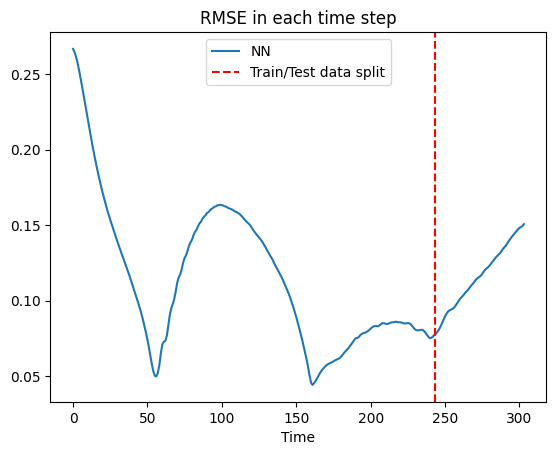

In [140]:
# Calculate RMSE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# Calculate the RMSE for the predictions
rmse_val = rmse(predictions, h_all)
print(f'RMSE: {rmse_val}')

# Plot error
error_NN = []

for i in range(h_all.shape[0]):
    error_NN.append(rmse(predictions[i], h_all[i]))

plt.plot(error_NN, label='NN')
plt.axvline(x=n_train, color='r', linestyle='--', label='Train/Test data split')
plt.xlabel('Time')
plt.title('RMSE in each time step')
plt.legend()
plt.show()


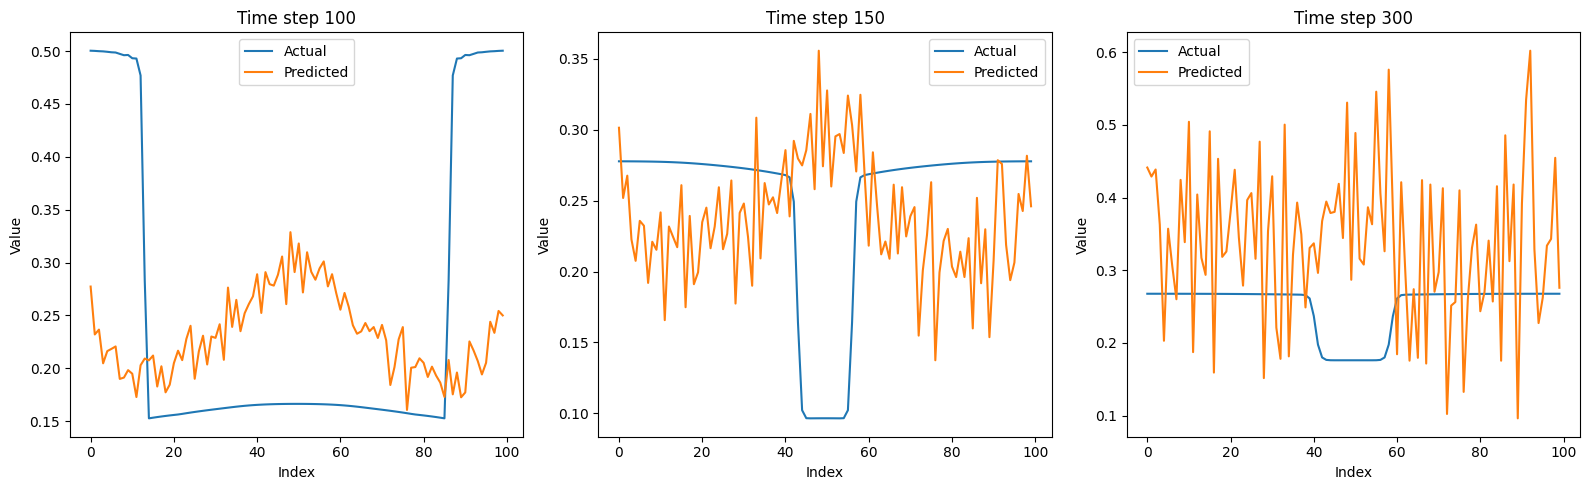

In [141]:
# Define the indices for the plots
indices = [100, 150, 300]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(indices), figsize=(16, 5))

# Plot for each index
for i, index in enumerate(indices):
    ax = axes[i]
    ax.plot(h_all[index], label='Actual')
    ax.plot(predictions[index], label='Predicted')
    ax.legend()
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.set_title(f'Time step {index}')

# Save the figure
plt.tight_layout()
plt.show()

## Solve the SWE using FNO

### Define network